# Анализ панельных данных: Дальневосточный Федеральный округ

Основные шаги:
1. Очистка данных: удаление признаков, у которых пропущено больше 2 лет (для любого региона), заполнение остальных пропусков медианой.
2. Корреляционный анализ: построение матрицы корреляций и выявление мультиколлинеарности.
3. Анализ факторов: выявление наиболее значимых факторов, влияющих на целевую переменную `Первичный рынок. Индекс цен на рынке жилья (все типы квартир)`.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

# Загрузка данных
df = pd.read_excel('DATASET.xlsx')
print(f"Исходный размер датасета: {df.shape}")
df.head(100)


Исходный размер датасета: (195, 120)


,region,year,"Численность постоянного населения на 1 число, тыс. человек","Численность постоянного населения в среднем за год, тыс. человек","Общий демографический прирост (-убыль), человек","Ожидаемая продолжительность жизни, лет","Естественный прирост населения, человек","Коэффициент естественного прироста населения (на 1000 населения), человек","Число родившихся, человек","Коэффициент рождаемости (на 1000 населения), человек",...,"Объем экспорта, млн долл.","Региональная структура экспорта, %","Темп роста объема экспорта, % к СППГ","Объем сырьевого экспорта, млн долл.","Доля сырьевого экспорта в общем объеме экспорта, %","Объем несырьевого экспорта, млн долл.","Доля несырьевого экспорта в общем объеме экспорта, %","Объем импорта, млн долл.","Региональная структура импорта, %","Темп роста объема импорта, % к СППГ"
0,Амурская область,2010,828.660,831.783,-4942,64.40,-1261,-1.5,11479.0,13.8,...,158.800000,0.827890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Амурская область,2011,820.627,824.644,-7087,64.81,-1000,-1.2,11211.0,13.6,...,228.600000,0.873596,143.954660,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Амурская область,2012,815.163,817.895,-4663,65.08,-340,-0.4,11740.0,14.4,...,407.500000,1.497198,178.258968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Амурская область,2013,808.726,811.944,-5636,66.32,133,0.2,11453.0,14.1,...,446.310465,1.499450,109.524040,205.540242,46.053198,240.770222,53.946802,NaN,NaN,NaN
4,Амурская область,2014,806.524,807.625,-1401,66.91,-136,-0.2,11094.0,13.7,...,383.344995,1.270500,85.892002,162.303744,42.338819,221.041252,57.661181,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Приморский край,2015,1918.531,1921.761,-4300,69.14,-1509,-0.8,24494.0,12.7,...,2707.903079,12.081917,68.122504,317.343280,11.719152,2390.559799,88.280848,NaN,NaN,NaN
96,Приморский край,2016,1910.444,1914.487,-5892,69.59,-2683,-1.4,23553.0,12.3,...,2175.691983,10.983598,80.346006,337.998849,15.535234,1837.693134,84.464766,3192.052196,50.977602,NaN
97,Приморский край,2017,1898.456,1904.449,-10079,70.27,-4488,-2.4,20973.0,11.0,...,3073.361982,13.196799,141.259057,386.742003,12.583679,2686.619979,87.416321,3745.659613,53.819715,NaN
98,Приморский край,2018,1886.265,1892.360,-10319,70.38,-5665,-3.0,19995.0,10.6,...,3413.320117,11.687132,111.061441,440.092608,12.893388,2973.227509,87.106612,4138.068071,60.593530,NaN


In [15]:
features = df.columns.to_list()
features

['region',
 'year',
 'Численность постоянного населения на 1 число, тыс. человек',
 'Численность постоянного населения в среднем за год, тыс. человек',
 'Общий демографический прирост (-убыль), человек',
 'Ожидаемая продолжительность жизни, лет ',
 'Естественный прирост населения, человек',
 'Коэффициент естественного прироста населения (на 1000 населения), человек',
 'Число родившихся, человек',
 'Коэффициент рождаемости (на 1000 населения), человек',
 'Число умерших, человек',
 'Коэффициент смертности (на 1000 населения), человек',
 'Миграционный прирост населения, человек ',
 'Коэффициент миграционного прироста населения (на 1000 населения), человек',
 'Число прибывших, человек',
 'Число выбывших, человек',
 'Численность занятых (в возрасте 15-72 лет), тыс. человек',
 'Численность безработных (в возрасте 15-72 лет), тыс. Человек',
 'Среднегодовая численность занятых в экономике (расчеты на основе интеграции данных), тыс. человек',
 'Уровень общей безработицы (по методологии МОТ) (в 

## 1. Очистка данных
Согласно условию: Наблюдения (признаки), в которых пропущено больше 2 лет, удаляем. Остальные пропущенные значения заполняем медианой.
Мы будем интерпретировать "пропущено больше 2 лет" как: если для какого-либо региона по данному признаку отсутствует более 2 лет наблюдений.


In [17]:
target = 'Первичный рынок. Индекс цен на рынке жилья (все типы квартир)'


max_missing_years = df.groupby('region').apply(lambda x: x.isna().sum()).max()

# признаки, у которых пропущено более 3 лет хотя бы в одном регионе
cols_to_drop = max_missing_years[max_missing_years > 3].index.tolist()


if target in cols_to_drop:
    cols_to_drop.remove(target)
    
for col in ['region', 'year']:
    if col in cols_to_drop:
        cols_to_drop.remove(col)

print(f"Количество признаков для удаления: {len(cols_to_drop)}")


df_cleaned = df.drop(columns=cols_to_drop)
print(f"Размер датасета после удаления признаков: {df_cleaned.shape}")


numeric_cols = df_cleaned.select_dtypes(include=[np.number]).drop(columns=['year'], errors='ignore').columns

df_cleaned[numeric_cols] = df_cleaned.groupby('region')[numeric_cols].transform(lambda x: x.fillna(x.median()))


df_cleaned[numeric_cols] = df_cleaned[numeric_cols].apply(lambda x: x.fillna(x.median()))
print(f"Осталось пропусков в данных: {df_cleaned.isna().sum().sum()}")

Количество признаков для удаления: 31
Размер датасета после удаления признаков: (195, 89)
Осталось пропусков в данных: 0


## 2. Корреляционный анализ и мультиколлинеарность
Построим матрицу корреляций для числовых признаков и выявим сильно скоррелированные пары (r > 0.8 или r < -0.8).


In [20]:
num_df = df_cleaned.select_dtypes(include=[np.number]).drop(columns=['year'])
corr_matrix = num_df.corr()

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Находим признаки с корреляцией > 0.7
high_corr = []
for col in upper_tri.columns:
    for idx in upper_tri.index:
        val = upper_tri.loc[idx, col]
        if abs(val) > 0.7:
            high_corr.append((idx, col, val))

high_corr_df = pd.DataFrame(high_corr, columns=['Признак 1', 'Признак 2', 'Корреляция']).sort_values(by='Корреляция', key=abs, ascending=False)
print(f"Найдено {len(high_corr_df)} пар сильно скоррелированных признаков (мультиколлинеарность).")
high_corr_df.head(100)


Найдено 494 пар сильно скоррелированных признаков (мультиколлинеарность).


,Признак 1,Признак 2,Корреляция
0,"Численность постоянного населения на 1 число, ...",Численность постоянного населения в среднем за...,0.999999
25,"Численность постоянного населения на 1 число, ...","Численность занятых (в возрасте 15-72 лет), ты...",0.999945
26,Численность постоянного населения в среднем за...,"Численность занятых (в возрасте 15-72 лет), ты...",0.999942
47,"Численность занятых (в возрасте 15-72 лет), ты...",Среднегодовая численность занятых в экономике ...,0.999917
40,"Численность постоянного населения на 1 число, ...",Среднегодовая численность занятых в экономике ...,0.999848
...,...,...,...
442,"Число прибывших, человек",Государственный и муниципальный долг субъектов...,0.975871
22,"Число умерших, человек","Число выбывших, человек",0.975822
16,"Число родившихся, человек","Число прибывших, человек",0.975812
467,"Число родившихся, человек","Объем экспорта, млн долл.",0.975586


<Axes: >

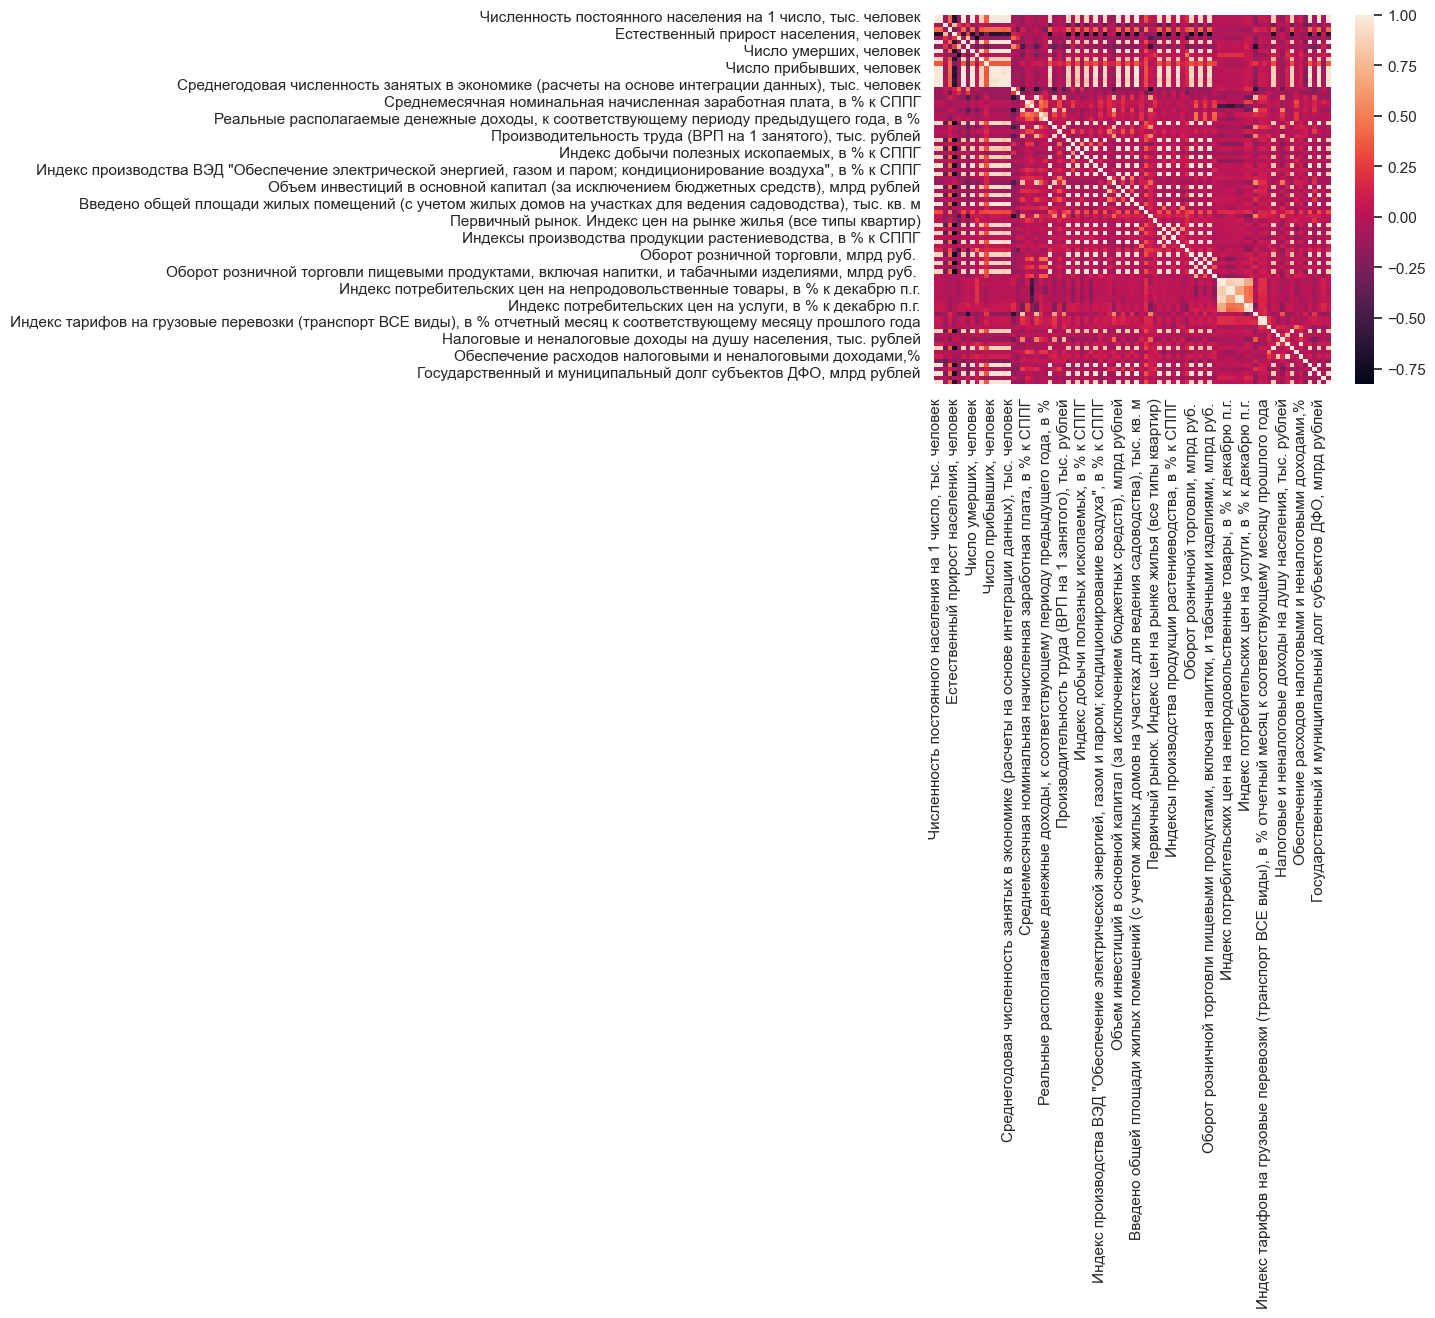

In [21]:
sns.heatmap(corr_matrix)

## 3. Факторы, влияющие на целевую переменную
Рассмотрим факторы, сильнее всего коррелирующие с изменением цены на первичном рынке жилья.
Также обучим случайный лес (RandomForestRegressor) для оценки важности признаков (Feature Importance).


In [22]:
target_corr = corr_matrix[target].drop(target).sort_values(ascending=False)

print("топ-10 признаков, положительно коррелирующих с индексом цены:")
print(target_corr.head(10))
print("\nТоп-10 факторов, отрицательно коррелирующих с индексом  цены:")
print(target_corr.tail(10))

X = num_df.drop(columns=[target])
y = num_df[target]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importances = pd.DataFrame({
    'Фактор': X.columns,
    'Важность': rf.feature_importances_
}).sort_values(by='Важность', ascending=False)

print("\nТоп-10 самых важных факторов (Random Forest):")
feature_importances.head(10)

топ-10 признаков, положительно коррелирующих с индексом цены:
Среднемесячная номинальная начисленная заработная плата, в % к СППГ                                                                                  0.220931
Коэффициент смертности (на 1000 населения), человек                                                                                                  0.215470
Отношение объема гос. долга к собственным доходам консолидированного бюджета, %                                                                      0.207092
Уровень рентабельности (убыточности) проданных товаров, продукции, работ, услуг  организаций сельского, лесного хозяйства, охоты и рыболовства, %    0.165341
Реальная начисленная заработная плата, в % к СППГ                                                                                                    0.162380
Индекс физического объема валового регионального продукта, в % к предыдущему году                                                                   

,Фактор,Важность
5,Коэффициент естественного прироста населения (...,0.077999
73,Доходы консолидированных бюджетов субъектов в ...,0.046381
11,Коэффициент миграционного прироста населения (...,0.045661
45,"Темп ввода жилых помещений, % СППГ",0.034195
64,Индекс потребительских цен на непродовольствен...,0.032536
20,Среднемесячная номинальная начисленная заработ...,0.030564
77,Расходы консолидированных бюджетов субъектов Д...,0.027740
50,Продукция растениеводства в фактически действо...,0.027616
4,"Естественный прирост населения, человек",0.025470
84,Государственный и муниципальный долг субъектов...,0.020365


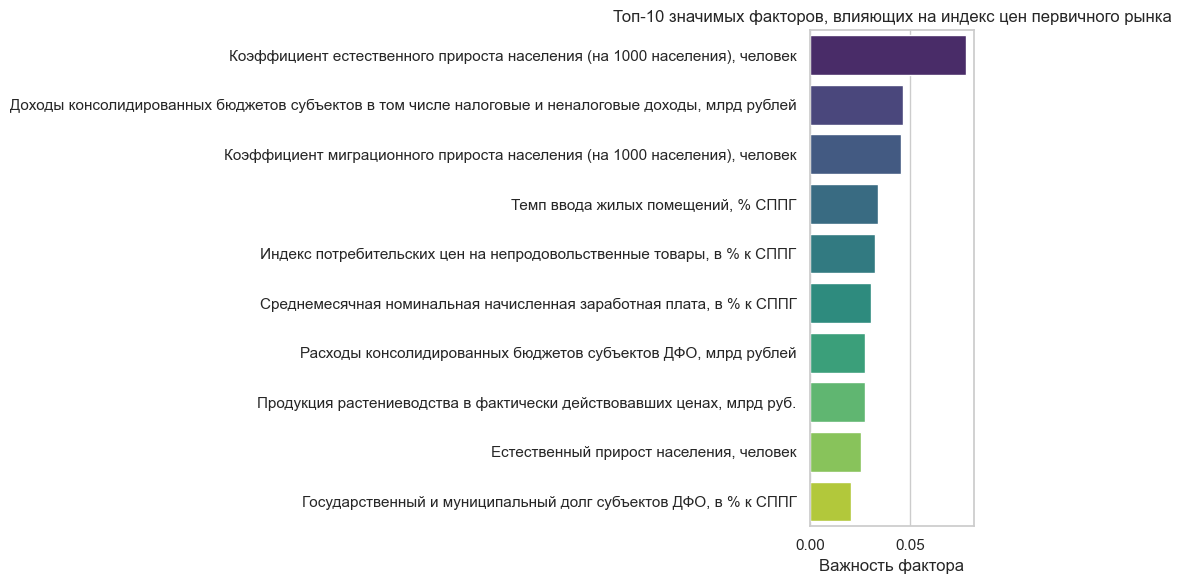

In [23]:

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances.head(10), x='Важность', y='Фактор', palette='viridis')
plt.title('Топ-10 значимых факторов, влияющих на индекс цен первичного рынка')
plt.xlabel('Важность фактора')
plt.ylabel('')
plt.tight_layout()
plt.show()